<a href="https://colab.research.google.com/github/P20241024/app/blob/main/P20241024_Modelo_Prediccion_por_hora_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

#Entrenamiento y creacion del modelo stacking:

In [ ]:
 drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar el dataset
df = pd.read_excel("/content/drive/MyDrive/Data/data_1k_tesis_CO2.xlsx")

In [ ]:
df.head(1000)

,ID,Timestamp,CO2 concentration in ppm,Temperature,Humidity,Light intensity,NODE ID
0,4678229,1533243314,2944,30.5,61.0,89,9
1,6642641,1533365453,2900,27.3,0.0,667,73
2,8267680,1533199750,347,-100.0,63.8,24,0
3,8267681,1533199751,287,27.6,63.8,25,0
4,8267682,1533199752,296,27.6,63.8,24,0
...,...,...,...,...,...,...,...
494,8268172,1533200260,219,28.2,64.9,17,1
495,8268173,1533200260,219,28.2,64.9,17,1
496,8268174,1533200172,239,28.7,65.1,27,0
497,8268175,1533200262,234,28.2,64.9,18,1


In [ ]:
# Convertir a numérico y manejar valores negativos
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce').apply(lambda x: max(0, x))
df['Light intensity'] = pd.to_numeric(df['Light intensity'], errors='coerce').apply(lambda x: max(0, x))
df['Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce').apply(lambda x: max(0, x))

In [ ]:
# Eliminar filas con valores NaN
df = df.dropna()

In [ ]:
# Ajustar Parametros / Generar características de fecha
np.random.seed(42)
n_samples = df.shape[0]
data = pd.DataFrame({
    'Year': np.random.randint(2018, 2021, n_samples),
    'Month': np.random.randint(1, 13, n_samples),
    'Day': np.random.randint(1, 29, n_samples),  # Limitar días para evitar errores de fecha
    'Hour': np.random.randint(0, 24, n_samples),
    'Temperature': df['Temperature'],
    'Humidity': df['Humidity'],
    'Light intensity': df['Light intensity'],
    'CO2 concentration in ppm': df['CO2 concentration in ppm']
})

In [ ]:
# Crear características adicionales de fecha y hora
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']], errors='coerce')
#data['Day of Week'] = data['Date'].dt.dayofweek
#data['Week of Year'] = data['Date'].dt.isocalendar().week
#data['Season'] = data['Month'].apply(lambda x: (x%12 + 3)//3)

# Eliminar la columna 'Date' ya que no se necesita
data = data.drop(columns=['Date'])

In [ ]:
# Dividir los datos en características y etiquetas
X = data.drop(columns=['CO2 concentration in ppm'])
y = data['CO2 concentration in ppm']

In [ ]:
print(X.head(10))

   Year  Month  Day  Hour  Temperature  Humidity  Light intensity
0  2020      4   11     7         30.5      61.0               89
1  2018     10    4    10         27.3       0.0              667
2  2020     10   15     3          0.0      63.8               24
3  2020      3    6    16         27.6      63.8               25
4  2018     10   22     6         27.6      63.8               24
5  2018      1   17     7         27.6      63.8               24
6  2020      8   24     2         27.6      63.8               23
7  2019      5    6    21         27.7      63.9               23
8  2020      4   19     1         27.7      63.9               23
9  2020      8   25    22         27.7      63.9               25


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Definir los modelos base
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('lr', LinearRegression()),
    ('svr', SVR(kernel='rbf')),
    ('lasso', Lasso()),
    ('ridge', Ridge()),
    ('elastic_net', ElasticNet()),
    ('gbm', GradientBoostingRegressor()),
    ('adaboost', AdaBoostRegressor()),
    ('xgb', XGBRegressor())
]

In [ ]:
# Definir el meta-modelo
meta_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [ ]:
# Crear y entrenar el modelo de stacking
kf = RepeatedKFold(n_splits=5,  n_repeats=2, random_state=42)
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

In [ ]:
# Definir la grilla de hiperparámetros para RandomizedSearchCV
param_dist = {
    'final_estimator__n_estimators': randint(50, 200),
    'final_estimator__learning_rate': uniform(0.05, 0.15)
}

In [ ]:
random_search = RandomizedSearchCV(stacking_model, param_dist, n_iter=50, cv=kf, scoring='neg_mean_squared_error', random_state=42)

In [ ]:
# Entrenar el modelo con los datos de entrenamiento
random_search.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=42),
                   estimator=StackingRegressor(estimators=[('rf',
                                                            RandomForestRegressor(random_state=42)),
                                                           ('lr',
                                                            LinearRegression()),
                                                           ('svr', SVR()),
                                                           ('lasso', Lasso()),
                                                           ('ridge', Ridge()),
                                                           ('elastic_net',
                                                            ElasticNet()),
                                                           ('gbm',
                                                            GradientBoostingRegressor()),
                                                           ('adaboost',
                                                            AdaBoostRegressor()),
                                                           ('xgb',
                                                            XGBRegr...
                                               final_estimator=GradientBoostingRegressor(random_state=42)),
                   n_iter=50,
                   param_distributions={'final_estimator__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c0e060fd3f0>,
                                        'final_estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0e02709d50>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
# Usar los mejores parámetros encontrados en RandomizedSearchCV para GridSearchCV
best_params = random_search.best_params_

In [ ]:
# param_grid = {
#     'final_estimator__n_estimators': [best_params['final_estimator__n_estimators']-10, best_params['final_estimator__n_estimators'], best_params['final_estimator__n_estimators']+10],
#     'final_estimator__learning_rate': [best_params['final_estimator__learning_rate']-0.01, best_params['final_estimator__learning_rate'], best_params['final_estimator__learning_rate']+0.01]
# }

In [ ]:
# Realizar GridSearchCV para encontrar los mejores hiperparámetros iniciales utilizando los parametro de RandomizedSearchCV
# grid_search = GridSearchCV(random_search.best_estimator_, param_grid, cv=kf, scoring='neg_mean_squared_error')


In [ ]:
#grid_search.fit(X_train_scaled, y_train)

In [ ]:
# Evaluar el modelo
#best_model = grid_search.best_estimator_
y_pred = random_search.predict(X_test_scaled)

#Validacion del modelo stacking

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mapeStacking = mean_absolute_percentage_error(y_test, y_pred)

In [ ]:
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mapeStacking}")

MSE: 136015.56970102168
MAE: 61.714662835391664
MAPE: 0.11680557648376302


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import joblib
modelo_lineal_regression = joblib.load('/content/drive/MyDrive/model_linearRegression.pkl')

In [ ]:

modelo_random_forest = joblib.load('/content/drive/MyDrive/model_randomForestRegressor.pkl')

In [ ]:
modelo_svr = joblib.load('/content/drive/MyDrive/model_svr.pkl')

In [ ]:
pred_lr = modelo_lineal_regression.predict(X_test_scaled)

In [ ]:
pred_rf = modelo_random_forest.predict(X_test_scaled)

In [ ]:
pred_svr = modelo_random_forest.predict(X_test_scaled)

In [ ]:
mapeLR = mean_absolute_percentage_error(y_test, pred_lr)
mapeRF = mean_absolute_percentage_error(y_test, pred_rf)
mape_svr = mean_absolute_percentage_error(y_test, pred_svr)

In [ ]:
print(f"mapeLR: {mapeLR}")
print(f"mapeRF: {mapeRF}")
print(f"mape_svr: {mape_svr}")

mapeLR: 0.21888921084674048
mapeRF: 0.06822791056691446
mape_svr: 0.06822791056691446


In [ ]:
# Calcular las métricas para cada modelo
metrics = {
    "Model": ["Stacking", "SVR", "Linear Regressor", "Random Forest Regressor"],
    "MSE": [
        mean_squared_error(y_test, y_pred),
        mean_squared_error(y_test, pred_lr),
        mean_squared_error(y_test, pred_rf),
        mean_squared_error(y_test, pred_svr)
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred),
        mean_absolute_error(y_test, pred_svr),
        mean_absolute_error(y_test, pred_lr),
        mean_absolute_error(y_test, pred_rf)
    ],
    "MAPE": [
        mapeStacking,
        mapeLR,
        mapeRF,
        mape_svr
    ]
}

In [ ]:
# Crear un DataFrame con las métricas
df_metrics = pd.DataFrame(metrics)

# Mostrar el DataFrame
print(df_metrics)

                     Model            MSE        MAE      MAPE
0                 Stacking  136015.569701  61.714663  0.116806
1                      SVR  196545.704960  42.403765  0.218889
2         Linear Regressor   67862.589206  95.558535  0.068228
3  Random Forest Regressor   67862.589206  42.403765  0.068228


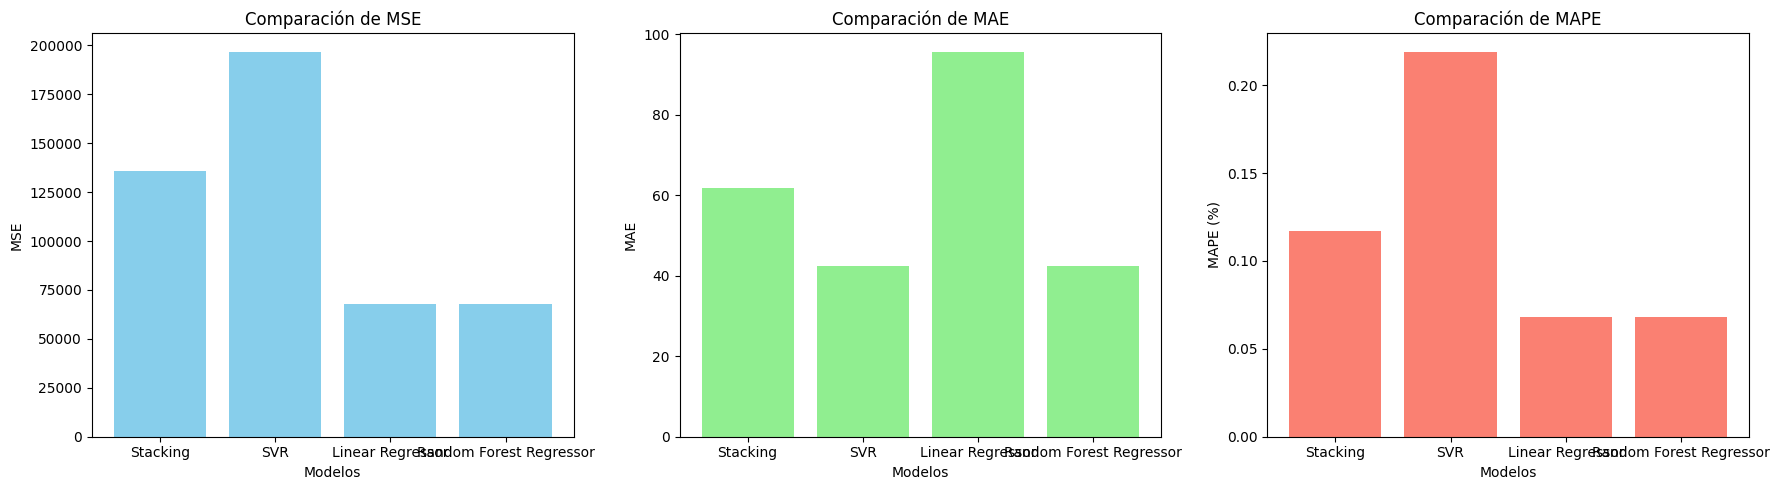

In [ ]:
# Crear gráficos de comparación
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de MSE
axes[0].bar(df_metrics['Model'], df_metrics['MSE'], color='skyblue')
axes[0].set_title('Comparación de MSE')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('MSE')

# Gráfico de MAE
axes[1].bar(df_metrics['Model'], df_metrics['MAE'], color='lightgreen')
axes[1].set_title('Comparación de MAE')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('MAE')

# Gráfico de MAPE
axes[2].bar(df_metrics['Model'], df_metrics['MAPE'], color='salmon')
axes[2].set_title('Comparación de MAPE')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('MAPE (%)')

plt.tight_layout()
plt.show()

#Generacion prediccion de CO2


In [ ]:
dfnew = pd.read_excel("/content/drive/MyDrive/Data/data_1k_tesis_CO2.xlsx")

In [ ]:
# Eliminar valores de CO2 por encima de un límite superior
upper_limit = 1000
df_filtered = df[df['CO2 concentration in ppm'] <= upper_limit]
# Recalcular la media y la desviación estándar con los datos filtrados
mean_co2_filtered = df_filtered['CO2 concentration in ppm'].mean()
std_co2_filtered = df_filtered['CO2 concentration in ppm'].std()

# Definir el límite como un múltiplo de la desviación estándar por encima de la media
limite_co2 = 545 #mean_co2_filtered + 2 * std_co2_filtered
print("Umbral de CO2 (datos filtrados):", limite_co2)

Umbral de CO2 (datos filtrados): 545


In [ ]:
# Fecha y hora inicial
fecha_inicial = pd.Timestamp('2022-04-20 14:15:00')
rango_fechas = pd.date_range(start=fecha_inicial, periods=len(dfnew), freq='H')
year = fecha_inicial.year
month = fecha_inicial.month
day = fecha_inicial.day
hour = fecha_inicial.hour

<ipython-input-38-de15a2c52ac8>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rango_fechas = pd.date_range(start=fecha_inicial, periods=len(dfnew), freq='H')


In [ ]:
# Verificar y convertir las columnas a string si no lo son, luego reemplazar comas y convertir a float
def clean_and_convert(column):
    return pd.to_numeric(column.astype(str).str.replace(',', '.'), errors='coerce').apply(lambda x: max(0, x))

In [ ]:
# Convertir a numérico y manejar los valores negativos en 'Temperature', 'Humidity' y 'Light intensity'
dfnew['Temperature'] = clean_and_convert(dfnew['Temperature'])
dfnew['Humidity'] = clean_and_convert(dfnew['Humidity'])
dfnew['Light intensity'] = clean_and_convert(dfnew['Light intensity'])

In [ ]:
# Función para predecir el CO2 para una fecha y hora específicas # SAVE CODIGO ORIGINAL
def predecir_co2_para_fecha(modelo, year, month, day, hour, temp, humidity, light_intensity):
    # Crear un DataFrame con los datos de entrada
    data = pd.DataFrame({
        'Year': [year] * len(temp),
        'Month': [month] * len(temp),
        'Day': [day] * len(temp),
        'Hour': [hour] * len(temp),
        'Temperature': temp,
        'Humidity': humidity,
        'Light intensity': light_intensity
    })
    # Realizar la predicción
    prediccion = modelo.predict(data)
    return prediccion

In [ ]:
# Función para predecir el CO2 para una fecha y hora específicas ## NUEVO
# def predecir_co2_para_fecha(modelo, year, month, day, hour, temp, humidity, light_intensity):
#     # Crear un DataFrame con los datos de entrada
#     data = pd.DataFrame({
#         'Year': [year] * len(temp),
#         'Month': [month] * len(temp),
#         'Day': [day] * len(temp),
#         'Hour': [hour] * len(temp),
#         'Temperature': temp,
#         'Humidity': humidity,
#         'Light intensity': light_intensity,
#         'Feature_8': temp,  # Removed the nested list creation
#         'Feature_9': humidity,  # Removed the nested list creation
#         'Feature_10': light_intensity  # Removed the nested list creation
#     })
#     # Realizar la predicción
#     prediccion = modelo.predict(data)
#     return prediccion

In [ ]:
# Predicción de CO2 para la fecha y hora inicial
prediccion_inicial = predecir_co2_para_fecha(random_search, year, month, day, hour, dfnew['Temperature'], dfnew['Humidity'], dfnew['Light intensity'])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/

In [ ]:
# Incrementar la hora
fecha_siguiente_hora = fecha_inicial + pd.Timedelta(hours=2)

In [ ]:
# Extraer año, mes, día y hora de la siguiente hora
year = fecha_siguiente_hora.year
month = fecha_siguiente_hora.month
day = fecha_siguiente_hora.day
hour = fecha_siguiente_hora.hour

In [ ]:
# Predicción de CO2 para la siguiente hora
prediccion_siguiente_hora = predecir_co2_para_fecha(random_search, year, month, day, hour, dfnew['Temperature'], dfnew['Humidity'], dfnew['Light intensity'])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/

In [ ]:
# Comparar las predicciones
# Calcular la media de los valores predichos
prediccion_inicial = np.mean(prediccion_inicial)
prediccion_siguiente_hora = np.mean(prediccion_siguiente_hora)
# print(f"Predicción de CO2 para la fecha y hora inicial: {prediccion_inicial}")
# print(f"Predicción de CO2 para la siguiente hora: {prediccion_siguiente_hora}")
if prediccion_inicial == prediccion_siguiente_hora:
    print("El valor de predicción para la siguiente hora es el mismo.")
else:
    print("El valor de predicción para la siguiente hora ha cambiado.")

El valor de predicción para la siguiente hora es el mismo.


In [ ]:
# Crear una lista con las predicciones
predicciones = [prediccion_inicial, prediccion_siguiente_hora]
labels = [f'Fecha: {fecha_inicial}', f'Fecha: {fecha_siguiente_hora}']

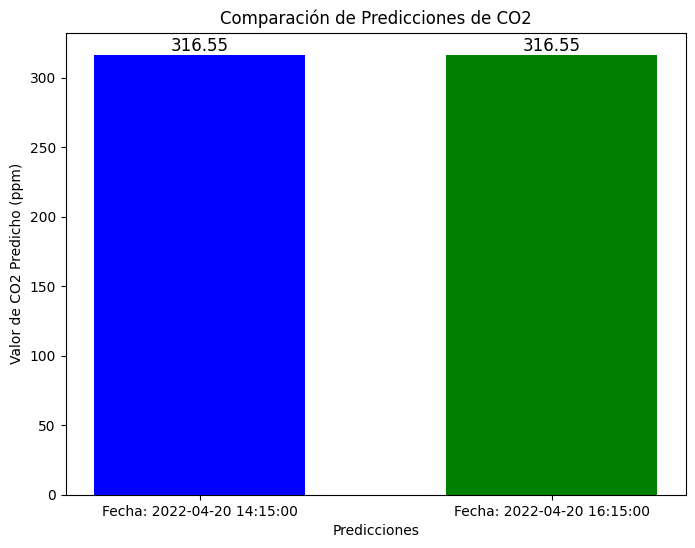

In [ ]:
# Crear el gráfico de barras ## NUEVO
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, predicciones, color=['blue', 'green'], width=0.6)

# Añadir etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

# Configurar las etiquetas y el título del gráfico
plt.xlabel('Predicciones')
plt.ylabel('Valor de CO2 Predicho (ppm)')
plt.title('Comparación de Predicciones de CO2')
# Mostrar el gráfico
plt.show()


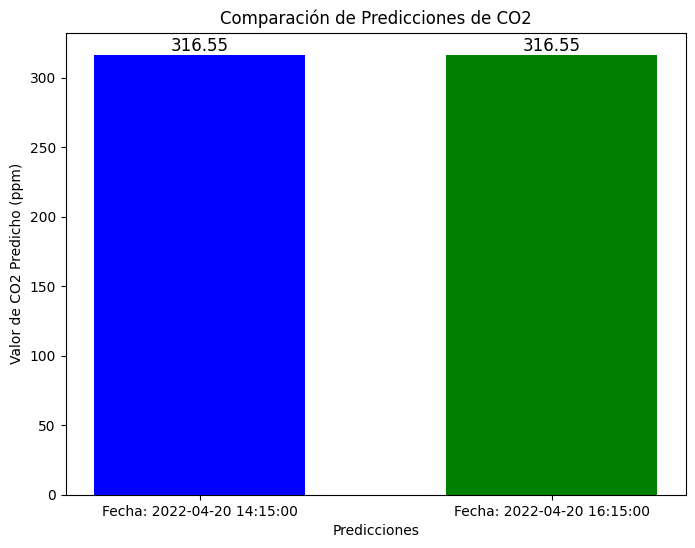

In [ ]:
# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, predicciones, color=['blue', 'green'], width=0.6)

# Añadir etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)

# Configurar las etiquetas y el título del gráfico
plt.xlabel('Predicciones')
plt.ylabel('Valor de CO2 Predicho (ppm)')
plt.title('Comparación de Predicciones de CO2')
# Mostrar el gráfico
plt.show()


In [ ]:
horas_del_dia = []
hora_actual = fecha_inicial.replace(minute=0, second=0, microsecond=0)
print(hora_actual)
# Agregar horas hasta llegar a la medianoche del mismo día
while hora_actual.hour != 0 and hora_actual.day == fecha_inicial.day:  # Asegurarse de que no exceda la medianoche
    horas_del_dia.append(hora_actual)  # Agregar la hora actual
    hora_actual += pd.Timedelta(hours=2)  # Incrementar en 4 horas

print(hora_actual)
print(horas_del_dia)

2022-04-20 14:00:00
2022-04-21 00:00:00
[Timestamp('2022-04-20 14:00:00'), Timestamp('2022-04-20 16:00:00'), Timestamp('2022-04-20 18:00:00'), Timestamp('2022-04-20 20:00:00'), Timestamp('2022-04-20 22:00:00')]


In [ ]:
# Obtener las horas del día como string en formato HH:MM:SS
horas_del_dia_str = []
for hora in horas_del_dia:
    if hora.hour < 12:
        horas_del_dia_str.append(hora.strftime('%I:%M %p'))  # Formato de 12 horas con AM/PM para horas antes de las 12 pm
    else:
        horas_del_dia_str.append(hora.strftime('%H:%M %p'))  # Formato de 24 horas con AM/PM para horas después de las 12 pm

In [ ]:
# realizo las predicciones y agrego al array
predicciones_por_hora = []
for hora in horas_del_dia:
    prediccion = predecir_co2_para_fecha(random_search, year, month, day, hora.hour, dfnew['Temperature'], dfnew['Humidity'], dfnew['Light intensity'])
    predicciones_por_hora.append(prediccion.mean())  # Si obtienes múltiples predicciones, puedes promediarlas

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/

#PREDICCION EN TIEMPO REAL

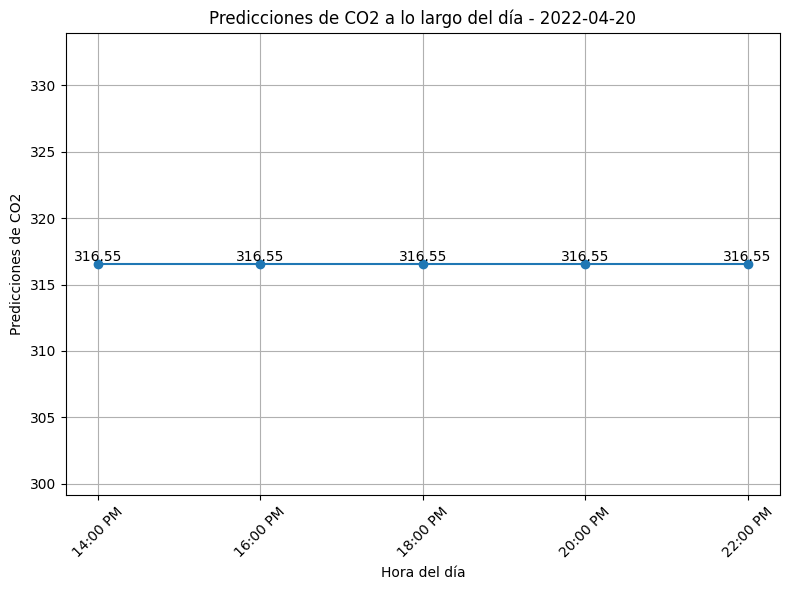

In [ ]:
# Crear el gráfico de líneas ## NUEVO
plt.figure(figsize=(8, 6))
plt.plot(horas_del_dia_str, predicciones_por_hora, marker='o', linestyle='-')
# MODIFICAR HORARIO DE TURNO SEGUN JORNADA LABORAL  //Agregar etiquetas con el valor de las predicciones en cada punto del gráfico
for x, y in zip(horas_del_dia_str, predicciones_por_hora):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10)
# Configurar las etiquetas y el título del gráfico
plt.xlabel('Hora del día')
plt.ylabel('Predicciones de CO2')
plt.title('Predicciones de CO2 a lo largo del día - {}'.format(fecha_inicial.strftime('%Y-%m-%d')))

# Mostrar el gráfico
plt.grid(True)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.tight_layout()
plt.show()

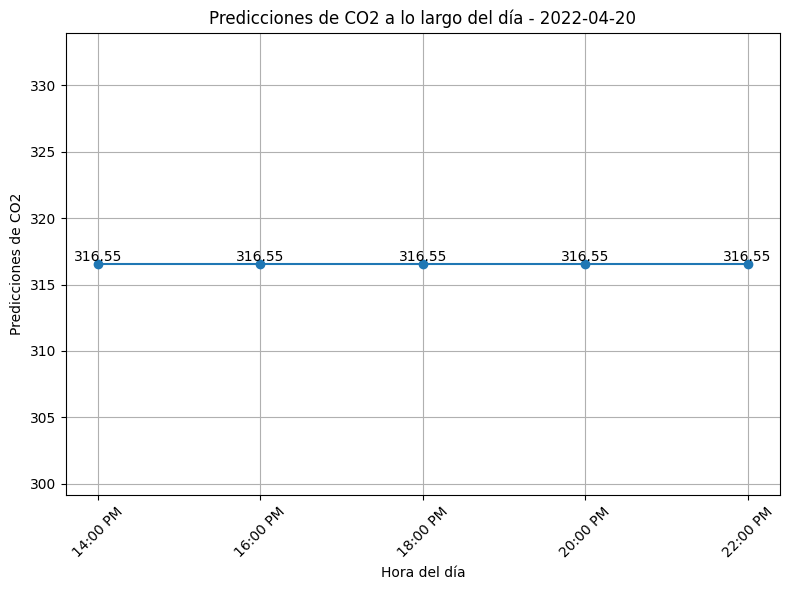

In [ ]:
# Crear el gráfico de líneas  ##SAVE CODIGO ORIGINAL
plt.figure(figsize=(8, 6))
plt.plot(horas_del_dia_str, predicciones_por_hora, marker='o', linestyle='-')
# MODIFICAR HORARIO DE TURNO SEGUN JORNADA LABORAL  //Agregar etiquetas con el valor de las predicciones en cada punto del gráfico
for x, y in zip(horas_del_dia_str, predicciones_por_hora):
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=10)
# Configurar las etiquetas y el título del gráfico
plt.xlabel('Hora del día')
plt.ylabel('Predicciones de CO2')
plt.title('Predicciones de CO2 a lo largo del día - {}'.format(fecha_inicial.strftime('%Y-%m-%d')))

# Mostrar el gráfico
plt.grid(True)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.tight_layout()
plt.show()

#SIMULACIONES DE EMERGENCIA



545


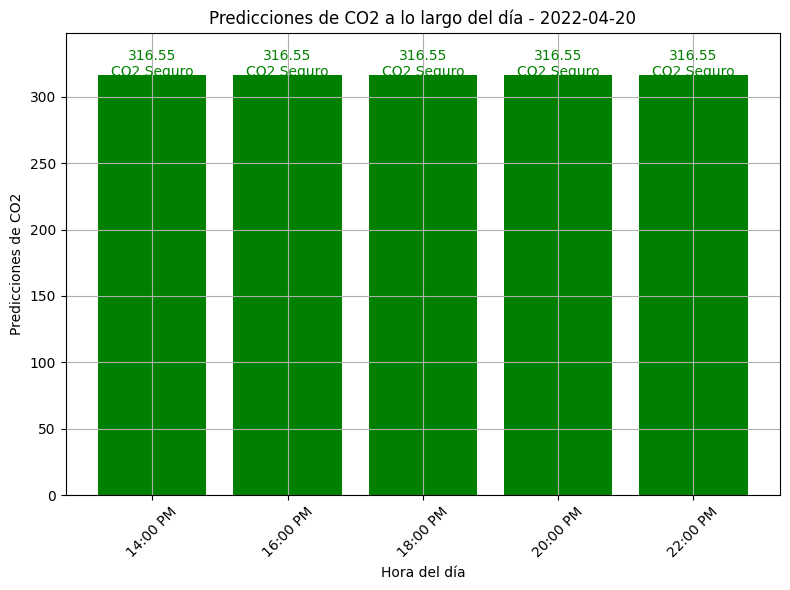

In [ ]:
## Crear el gráfico de barras con colores específicos ##NUEVO
print(limite_co2)
colores = ['red' if pred > limite_co2 else 'green' for pred in predicciones_por_hora]
plt.figure(figsize=(8, 6))
barras = plt.bar(horas_del_dia_str, predicciones_por_hora, color=colores)
# Agregar etiquetas con el valor de las predicciones en cada barra del gráfico
for barra, pred in zip(barras, predicciones_por_hora):
    altura = barra.get_height()
    if pred > limite_co2:
        plt.text(barra.get_x() + barra.get_width() / 2, altura - 3, f'{pred:.2f}\nCO2 Peligroso', ha='center', va='bottom', fontsize=10, color='red')
    else:
        plt.text(barra.get_x() + barra.get_width() / 2, altura - 3, f'{pred:.2f}\nCO2 Seguro', ha='center', va='bottom', fontsize=10, color='green')
# Configurar las etiquetas y el título del gráfico
plt.xlabel('Hora del día')
plt.ylabel('Predicciones de CO2')
plt.title('Predicciones de CO2 a lo largo del día - {}'.format(fecha_inicial.strftime('%Y-%m-%d')))

# Ajustar los límites del eje y para que el gráfico no sea muy alto
plt.ylim(0, max(predicciones_por_hora) * 1.1)

# Mostrar el gráfico
plt.grid(True)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.tight_layout()
plt.show()

545


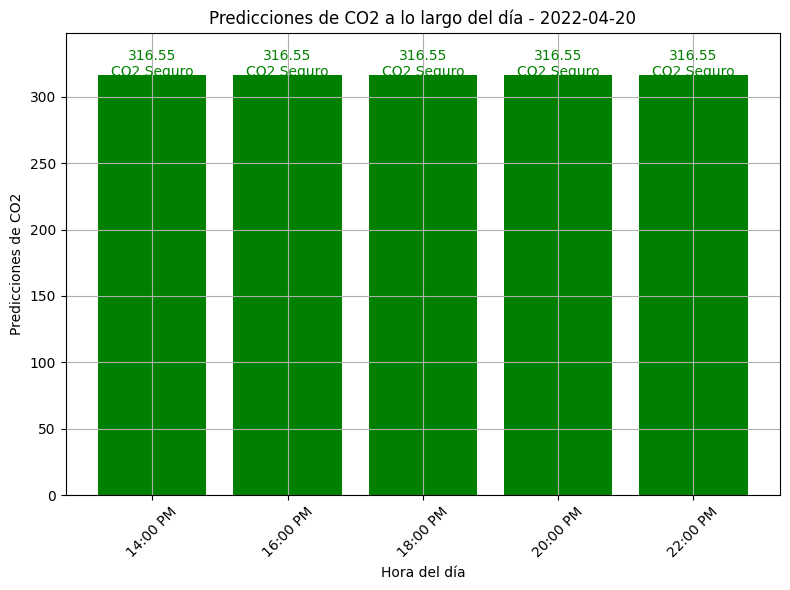

In [ ]:
## Crear el gráfico de barras con colores específicos ##PREDICCION
print(limite_co2)
colores = ['red' if pred > limite_co2 else 'green' for pred in predicciones_por_hora]
plt.figure(figsize=(8, 6))
barras = plt.bar(horas_del_dia_str, predicciones_por_hora, color=colores)
# Agregar etiquetas con el valor de las predicciones en cada barra del gráfico
for barra, pred in zip(barras, predicciones_por_hora):
    altura = barra.get_height()
    if pred > limite_co2:
        plt.text(barra.get_x() + barra.get_width() / 2, altura - 3, f'{pred:.2f}\nCO2 Peligroso', ha='center', va='bottom', fontsize=10, color='red')
    else:
        plt.text(barra.get_x() + barra.get_width() / 2, altura - 3, f'{pred:.2f}\nCO2 Seguro', ha='center', va='bottom', fontsize=10, color='green')
# Configurar las etiquetas y el título del gráfico
plt.xlabel('Hora del día')
plt.ylabel('Predicciones de CO2')
plt.title('Predicciones de CO2 a lo largo del día - {}'.format(fecha_inicial.strftime('%Y-%m-%d')))

# Ajustar los límites del eje y para que el gráfico no sea muy alto
plt.ylim(0, max(predicciones_por_hora) * 1.1)

# Mostrar el gráfico
plt.grid(True)
plt.xticks(rotation=45)  # Rotar etiquetas del eje x para mejor legibilidad
plt.tight_layout()
plt.show()

In [ ]:
categorias_reales = dfnew['CO2 concentration in ppm']

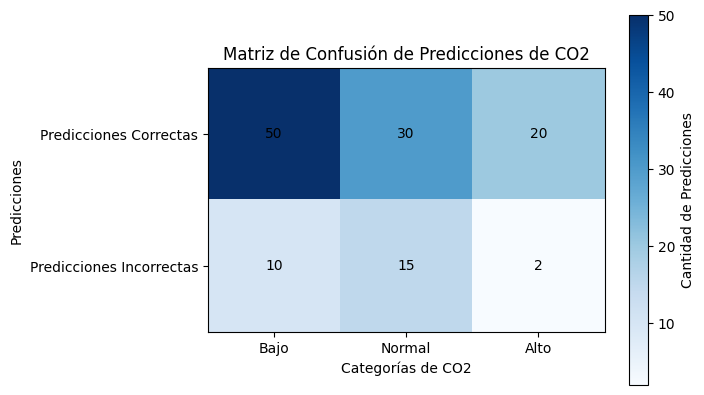

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
predicciones_correctas = {'Bajo': 50, 'Normal': 30, 'Alto': 20}
predicciones_incorrectas = {'Bajo': 10, 'Normal': 15, 'Alto': 2}

# Obtener las etiquetas y los valores de cada categoría
categorias = list(predicciones_correctas.keys())
correctas = np.array([predicciones_correctas[categoria] for categoria in categorias])
incorrectas = np.array([predicciones_incorrectas[categoria] for categoria in categorias])

# Crear la matriz de confusión modificada para mostrar los conteos de predicciones correctas e incorrectas
matriz_confusion = np.vstack((correctas, incorrectas))

# Visualizar la matriz de confusión
plt.imshow(matriz_confusion, cmap='Blues')

# Mostrar las etiquetas
plt.xticks(np.arange(len(categorias)), categorias)
plt.yticks([0, 1], ['Predicciones Correctas', 'Predicciones Incorrectas'])
plt.xlabel('Categorías de CO2')
plt.ylabel('Predicciones')

# Agregar los valores dentro de cada celda
for i in range(len(categorias)):
    for j in range(2):
        plt.text(i, j, matriz_confusion[j, i], ha='center', va='center', color='black')

# Mostrar el gráfico
plt.title('Matriz de Confusión de Predicciones de CO2')
plt.colorbar(label='Cantidad de Predicciones')
plt.show()


#DESPLIEGUE DE LA APLICACION WEB

In [ ]:
#Instalacion del StreamLit
!pip install streamlit pandas numpy scikit-learn xgboost matplotlib joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 8.1 MB/s eta 0:00:00


In [ ]:
#Instalacion del LocalTunnel
!npm install -g localtunnel


added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [ ]:
#GENERAR KEY (Guardar codigo)
!wget -q -O - ipv4.icanhazip.com

34.80.45.71


In [ ]:
#GENERAR Y ABRIR PUERTO STREAMLIT
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.80.45.71:8501

your url is: https://pink-swans-allow.loca.lt
  Stopping...
^C


In [ ]:
#ENTRENAR SCALER
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [ ]:
#GUARDAR SCALER
#joblib.dump(scaler, '/content/drive/MyDrive/scaler.pkl')

['/content/drive/MyDrive/scaler.pkl']